In [36]:
# Initialize Otter
import otter
grader = otter.Notebook("Project2.ipynb")

In [37]:
rng_seed = 42

# Project 2: 
## Neural Networks, Finite Differences

## Problem 1: Neural Network from Scratch using Numpy

Unfortunately, DataHub does not have GPUs for hard machine learning tasks. In this project, we will instead focus on going back to the basics: Writing out a neural network using numpy.

### Problem Goals:
    
The goal of this problem is to understand the logic behind neural networks, including the weights, activation, the optimization algorithm (Stochastic Gradient Descent) and especially backpropagation. These are all topics that have been covered in the course so far, and I would recommend you go back through the course notes and material for each.

In this project, you will **implement a feed-forward neural network (multi-layer perceptron)** entirely from scratch using **NumPy only** — no deep learning libraries such as PyTorch, TensorFlow, or JAX. You will apply your network to a **real dataset** from scikit-learn (`load_digits`), train it to classify handwritten digits (0–9), and compare your results to scikit-learn's `MLPClassifier`.

### Data:

We will use **`sklearn.datasets.load_digits()`** (think of it as a lighter version of MNIST), with the goal of writing our own classifier to classify this data. 

This dataset contains **1797 images**, each an 8×8 grayscale pixel grid (64 features), labeled with an integer digit (0–9). No preprocessing beyond standardization is needed — the features are already numeric.

## What you submit
See below for the separate parts of the problem. In summary,  you will be submittin a `.ipynb` in a PDF file with:

1. **Working implementation** of an MLP classifier (your own code using NumPy only).
2. **Training logs/plots** for loss/accuracy on train and validation.
3. **Final metrics** on a held‑out test set.
4. **Baseline comparison** vs ``sklearn.neural_networl.MLPClassifier`.
5. **Short write‑up (≤300 words)**: design choices, what worked/didn’t, any regularization tricks.

### Submission
Submit via Gradescope by uploading a `.pdf` file. Before submitting, you should restart and run your notebook from top-to-bottom, without any errors. You can use Cmd + P to generate the submission PDF within DataHub.

### Rules and Hints
- You may use `numpy`, `matplotlib`, and `sklearn` (for data utilities and baseline only).
- No `torch`, `tensorflow`, `jax`, or external neural network libraries.
- Numerical stability matters! Always use `log(np.clip(...))` in loss computations (see below).
- Use vectorized NumPy operations (avoid Python loops in your core model).
- Comment your code and make it clear what each step does.
- Your code must be your own.
- **You may use material on the [Course Github](https://github.com/MarkusHohle/UC-Berkeley/tree/main/Phys-188_288/Fall%202025/10%20SGD%20ANN%20and%20basic%20Architecture/Codes) to help you write the code.**

### Extra Background information: Softmax and Categorical Cross-Entropy Loss

As we are now considering a multi-category classification task, we should re-visit the methods used for multi-class classification. Specifically, the activation function Softmax and Categorical Cross-Entropy Loss.

#### **Softmax: Turning outputs into probabilities**

The final layer of your MLP produces **logits** — real-valued scores, one for each class.
Let the logits for a single example be  
$$ \mathbf{z} = (z_1, z_2, \ldots, z_C)$$
where $C$ is the number of classes (here $C = 10$).

The **softmax function** converts these logits into a probability distribution:
$$\text{softmax}(z_i) = p_i = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}$$
Each $p_i$ satisfies $0 \le p_i \le 1$ and $\sum_i p_i = 1$.

However, it is important to note that exponentials can overflow for large logit values. To avoid this, subtract the largest logit before exponentiating (it does not change the result):
$$ p_i = \frac{e^{z_i - z_{\max}}}{\sum_j e^{z_j - z_{\max}}}$$
where $z_{\max} = \max_j z_j$. This is the **stable softmax** implementation you will use.

#### **Categorical Cross-Entropy Loss**

Once we have predicted probabilities $p_i$, we want the loss to be **small** when the model assigns high probability to the true class.

If the true label is represented as a one-hot vector (a vector of length $C$ for $C$ classes, with:
$$ \mathbf{y} = (y_1, \ldots, y_C)
\quad\text{where } y_k = 
\begin{cases}
1 & \text{if class } k \text{ is correct}\\
0 & \text{otherwise}
\end{cases}
$$
then the **cross-entropy loss** for one example is:
$$
\mathcal{L} = -\sum_{i=1}^{C} y_i \, \log(p_i)
$$
Since only one $y_i$ equals 1, this simplifies to:
$$
\mathcal{L} = -\log(p_{\text{true class}})
$$
The average loss over all $N$ samples in a batch is:
$$
J = -\frac{1}{N} \sum_{n=1}^{N} \log p^{(n)}_{\text{true class}}
$$
Conceptually, **cross-entropy** measures how far the predicted probability distribution $p$ is from the true one-hot distribution $y$. Minimizing cross-entropy encourages \(p_{\text{true}}\to 1\) and others \(\to 0\).
                 
**To implement cross-entropy loss numerically**, we must implement a cutoff on $p$ to avoid $\log(0)$. You can use `np.log(np.clip(p, 1e-12, 1.0))` to achieve this.

In the backpropagation step, the combination of softmax and cross-entropy produces a particularly simple and elegant gradient:
$$
\frac{\partial \mathcal{L}}{\partial z_i} = p_i - y_i
$$


In [38]:
# Setup: imports, reproducibility, plotting defaults
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle

np.set_printoptions(precision=4, suppress=True)
rng = np.random.default_rng(42)  # reproducible

<!-- BEGIN QUESTION -->

#### Part 1 — Setup and Data Handling 
1. Load, inspect and visualize the dataset (`load_digits`). (This is done for you)
2. Split into **train/validation/test** sets (≈70% / 15% / 15%).
3. Standardize features using `StandardScaler`.

X shape: (1797, 64), y shape: (1797,), classes: [0 1 2 3 4 5 6 7 8 9]


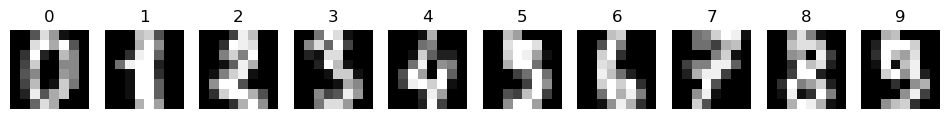

In [39]:
# Load and inspect the digits dataset
digits = load_digits()
X = digits.data.astype(np.float64)   # shape: (n_samples, 64)
y = digits.target.astype(np.int64)   # shape: (n_samples,)

print(f"X shape: {X.shape}, y shape: {y.shape}, classes: {np.unique(y)}")

# Visual sanity check
fig, axes = plt.subplots(1, 10, figsize=(12, 2.5))
for ax, i in zip(axes, range(10)):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(str(y[i]))
    ax.axis('off')
plt.show()

In [40]:
# Split and scale the data
# First split out test set (~15%) then split remaining into train (~70%) and val (~15%)
X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.15, random_state=rng_seed, stratify=y)
# Now split X_tmp into train and val so that train is approx 70% of total
val_fraction_of_tmp = 0.15 / (1 - 0.15)  # desired val fraction relative to tmp
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=val_fraction_of_tmp, random_state=rng_seed, stratify=y_tmp
)

# Standardize features using StandardScaler fit on training set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("Train/Val/Test shapes:", X_train.shape, X_val.shape, X_test.shape)

Train/Val/Test shapes: (1257, 64) (270, 64) (270, 64)


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Part 2 — Build a Multi-Layer Perceptron (MLP)
Implement your own MLP class in NumPy. Make sure your class supports:
- Arbitrary number of neurons (e.g., `[64, 128, 64, 10]`, here 64 is the input dimension, and 10 is the output dimension).
- Activation functions: ReLU, Tanh, or Sigmoid. (Hint: You should define helper functions for these activations as well as their analytic gradients for backpropagation)
- Forward propagation and softmax output.
- Cross-entropy loss.
- Backpropagation for weight and bias gradients.
- Random weight initialization. (Typically random normal distributions. E.g. look into the He or Xavier initializations.)
- Optional: L2 regularization (`λ` parameter).

Important Notes:
- No autograd or deep learning libraries allowed.
- All derivatives must be implemented using NumPy operations.

A skeleton code design template for your MLP class is provided below. You do not have to follow it.

Some design notes for your MLP class, you do not have to follow it.

Write the following core methods:

- `__init__`: set up network architecture (layer sizes, activations, weight initialization, etc.).
- `forward`: perform one full forward pass through all layers and return the final logits.
- `loss_and_grads`: compute the loss (cross-entropy) and gradients of all parameters using backpropagation.
- `backward`: perform the backward pass with backpropagation. This could be integrated with the above.
- `predict`: use a forward pass to output the most likely class labels.

You may store intermediate quantities (e.g. activations and pre-activations) in a cache during the forward pass to reuse during backpropagation.

Try to **vectorize operations** using NumPy instead of writing loops over samples.  
Make sure you test each component (forward shapes, loss computation, gradient correctness) step by step before combining everything.

In [41]:
class MLPNumPy:
    """A simple fully-connected MLP implemented with NumPy.
    Supports arbitrary layer sizes and activations (relu, tanh, sigmoid).
    Uses softmax + cross-entropy for multi-class classification.
    """
    def __init__(self, layer_sizes, activation='relu', weight_scale=None, weight_decay=0.0, seed=42):
        self.layer_sizes = list(layer_sizes)
        assert len(self.layer_sizes) >= 2, "Need input and output sizes"
        self.L = len(self.layer_sizes) - 1  # number of weight layers
        self.activation = activation.lower()
        self.weight_decay = float(weight_decay)
        self.rng = np.random.default_rng(seed)

        # initialize weights and biases
        self.W = []
        self.b = []
        for i in range(self.L):
            in_dim = self.layer_sizes[i]
            out_dim = self.layer_sizes[i+1]
            # He init for relu, Xavier for tanh/sigmoid
            if weight_scale is not None:
                scale = weight_scale
            else:
                if self.activation == 'relu':
                    scale = np.sqrt(2.0 / in_dim)
                else:
                    scale = np.sqrt(1.0 / in_dim)
            W = self.rng.normal(loc=0.0, scale=scale, size=(in_dim, out_dim))
            b = np.zeros(out_dim)
            self.W.append(W)
            self.b.append(b)

    # Activation helpers and gradients
    def _activate(self, x):
        if self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'tanh':
            return np.tanh(x)
        elif self.activation == 'sigmoid':
            return 1.0 / (1.0 + np.exp(-x))
        else:
            raise ValueError('Unknown activation')

    def _activate_grad_from_activation(self, a):
        # Given post-activation a, compute derivative of activation w.r.t. pre-activation
        if self.activation == 'relu':
            return (a > 0).astype(float)
        elif self.activation == 'tanh':
            return 1.0 - a**2
        elif self.activation == 'sigmoid':
            return a * (1.0 - a)
        else:
            raise ValueError('Unknown activation')

    def forward(self, X):
        """Forward pass: returns logits and caches activations for backprop."""
        A = X
        activations = [A]
        pre_acts = []
        for i in range(self.L - 1):
            Z = A.dot(self.W[i]) + self.b[i]
            pre_acts.append(Z)
            A = self._activate(Z)
            activations.append(A)
        # last layer (logits)
        ZL = A.dot(self.W[-1]) + self.b[-1]
        pre_acts.append(ZL)
        activations.append(ZL)  # store logits in activations for convenience
        cache = {'activations': activations, 'pre_acts': pre_acts}
        return ZL, cache

    def _softmax(self, logits):
        # stable softmax over last axis
        z = logits - np.max(logits, axis=1, keepdims=True)
        expz = np.exp(z)
        probs = expz / np.sum(expz, axis=1, keepdims=True)
        return probs

    def loss_and_grads(self, X, y):
        """Compute cross-entropy loss and gradients for a batch (X,y).
        Returns (loss, grads) where grads is dict with 'W' and 'b' lists.
        """
        N = X.shape[0]
        logits, cache = self.forward(X)
        probs = self._softmax(logits)

        # one-hot encode y
        C = logits.shape[1]
        y_onehot = np.zeros((N, C))
        y_onehot[np.arange(N), y] = 1.0

        # loss
        eps = 1e-12
        loss = -np.mean(np.sum(y_onehot * np.log(np.clip(probs, eps, 1.0)), axis=1))
        # weight decay (L2)
        if self.weight_decay:
            reg = 0.0
            for W in self.W:
                reg += 0.5 * self.weight_decay * np.sum(W * W)
            loss += reg

        # gradient of logits
        dZ = (probs - y_onehot) / N

        grads_W = [None] * self.L
        grads_b = [None] * self.L

        activations = cache['activations']

        # backprop through last layer
        A_prev = activations[-2]
        grads_W[-1] = A_prev.T.dot(dZ) + self.weight_decay * self.W[-1]
        grads_b[-1] = np.sum(dZ, axis=0)

        dA_prev = dZ.dot(self.W[-1].T)

        # backprop through hidden layers
        for i in range(self.L - 2, -1, -1):
            A_i = activations[i+1]  # post-activation at layer i
            grad_act = self._activate_grad_from_activation(A_i)
            dZ = dA_prev * grad_act
            A_prev = activations[i]
            grads_W[i] = A_prev.T.dot(dZ) + self.weight_decay * self.W[i]
            grads_b[i] = np.sum(dZ, axis=0)
            if i > 0:
                dA_prev = dZ.dot(self.W[i].T)

        grads = {'W': grads_W, 'b': grads_b}
        return loss, grads

    def predict(self, X):
        logits, _ = self.forward(X)
        probs = self._softmax(logits)
        return np.argmax(probs, axis=1)

    def predict_proba(self, X):
        logits, _ = self.forward(X)
        return self._softmax(logits)


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Part 3 — Training Loop
Implement a training routine that:
- Uses **mini-batch SGD** (optionally with momentum).
- Tracks **training and validation loss/accuracy** over epochs.
- Includes an **optional learning-rate decay** parameter.
- Supports **early stopping** based on validation loss.

Plot the training curves (loss and accuracy vs. epoch).


Epoch   1: train_loss=0.7511, val_loss=0.8255, train_acc=0.8115, val_acc=0.8037
Epoch   2: train_loss=0.3460, val_loss=0.4419, train_acc=0.9141, val_acc=0.8852
Epoch   3: train_loss=0.2442, val_loss=0.3582, train_acc=0.9483, val_acc=0.8963
Epoch   4: train_loss=0.1967, val_loss=0.3142, train_acc=0.9642, val_acc=0.9111
Epoch   5: train_loss=0.1682, val_loss=0.2841, train_acc=0.9698, val_acc=0.9185
Epoch   6: train_loss=0.1485, val_loss=0.2671, train_acc=0.9737, val_acc=0.9148
Epoch   7: train_loss=0.1324, val_loss=0.2523, train_acc=0.9785, val_acc=0.9185
Epoch   8: train_loss=0.1201, val_loss=0.2427, train_acc=0.9833, val_acc=0.9185
Epoch   9: train_loss=0.1103, val_loss=0.2333, train_acc=0.9849, val_acc=0.9185
Epoch  10: train_loss=0.1021, val_loss=0.2233, train_acc=0.9865, val_acc=0.9222
Epoch  11: train_loss=0.0950, val_loss=0.2178, train_acc=0.9873, val_acc=0.9185
Epoch  12: train_loss=0.0889, val_loss=0.2127, train_acc=0.9905, val_acc=0.9222
Epoch  13: train_loss=0.0836, val_loss=0

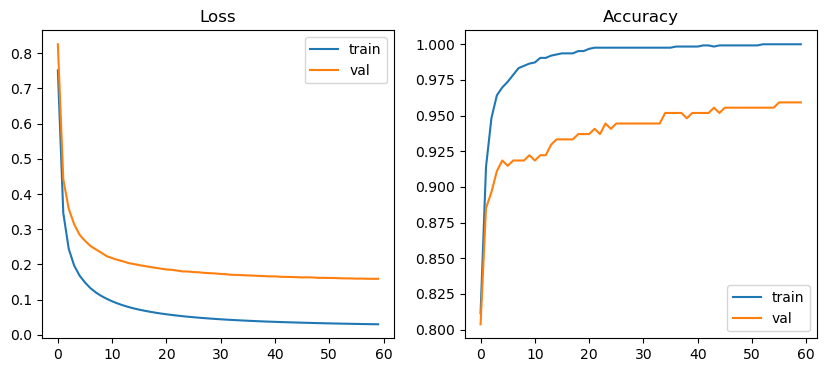

In [42]:
def train_mlp(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=64,
              lr=1e-2, momentum=0.0, weight_decay=0.0, lr_decay=1.0, early_stopping_patience=None,
              verbose=True):
    # initialize velocities for momentum
    velocities_W = [np.zeros_like(W) for W in model.W]
    velocities_b = [np.zeros_like(b) for b in model.b]

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_loss = np.inf
    best_weights = None
    patience_count = 0

    N = X_train.shape[0]
    for epoch in range(1, epochs+1):
        # shuffle training data
        perm = np.random.permutation(N)
        X_shuff = X_train[perm]
        y_shuff = y_train[perm]

        # mini-batch SGD
        for i in range(0, N, batch_size):
            Xb = X_shuff[i:i+batch_size]
            yb = y_shuff[i:i+batch_size]
            loss, grads = model.loss_and_grads(Xb, yb)

            # update parameters with momentum
            for idx in range(model.L):
                # update velocities
                velocities_W[idx] = momentum * velocities_W[idx] - lr * grads['W'][idx]
                velocities_b[idx] = momentum * velocities_b[idx] - lr * grads['b'][idx]
                # apply update
                model.W[idx] += velocities_W[idx]
                model.b[idx] += velocities_b[idx]

        # end of epoch: evaluate
        train_loss, _ = model.loss_and_grads(X_train, y_train)
        val_loss, _ = model.loss_and_grads(X_val, y_val)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        train_acc = np.mean(y_train_pred == y_train)
        val_acc = np.mean(y_val_pred == y_val)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        if verbose:
            print(f"Epoch {epoch:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

        # learning rate decay
        lr *= lr_decay

        # early stopping
        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_weights = ([W.copy() for W in model.W], [b.copy() for b in model.b])
            patience_count = 0
        else:
            patience_count += 1
            if early_stopping_patience is not None and patience_count >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch}")
                break

    # restore best weights
    if best_weights is not None:
        model.W, model.b = best_weights

    return history


# Quick instance and training run with modest settings
input_dim = X_train.shape[1]
hidden = [128]
layer_sizes = [input_dim] + hidden + [10]
model = MLPNumPy(layer_sizes, activation='relu', weight_decay=1e-4, seed=rng_seed)

history = train_mlp(model, X_train, y_train, X_val, y_val,
                    epochs=60, batch_size=64, lr=1e-2, momentum=0.9,
                    weight_decay=1e-4, lr_decay=0.995, early_stopping_patience=10)

# plot training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='train')
plt.plot(history['val_acc'], label='val')
plt.title('Accuracy')
plt.legend()
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Part 4 — Evaluation
1. Evaluate the trained model on the **test set** and report:
   - Test accuracy.
   - Classification report (precision, recall, F1).
   - Confusion matrix (visualized as a heatmap).
2. Train a **baseline model** using `sklearn.neural_networl.MLPClassifier` and report the same metrics for comparison. 

   (If you want, you can use the `sgd` solver in `MLPClassifier` and the same layers/activation to replicate your model, though this is not necessary)

NumPy MLP Test accuracy: 0.9741
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.89      0.93      0.91        27
           2       1.00      1.00      1.00        27
           3       1.00      1.00      1.00        28
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        27
           6       0.96      1.00      0.98        27
           7       0.96      1.00      0.98        27
           8       0.96      0.88      0.92        26
           9       0.96      0.93      0.94        27

    accuracy                           0.97       270
   macro avg       0.97      0.97      0.97       270
weighted avg       0.97      0.97      0.97       270



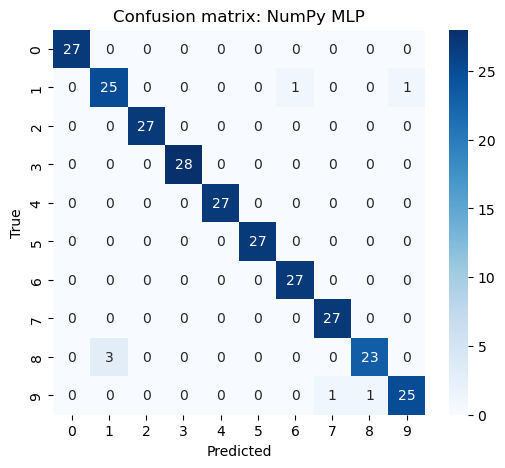


Training sklearn MLPClassifier baseline...
sklearn MLPClassifier Test accuracy: 0.9889
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.93      0.96      0.95        27
           2       1.00      1.00      1.00        27
           3       1.00      1.00      1.00        28
           4       0.96      1.00      0.98        27
           5       1.00      1.00      1.00        27
           6       1.00      1.00      1.00        27
           7       1.00      1.00      1.00        27
           8       1.00      0.92      0.96        26
           9       1.00      1.00      1.00        27

    accuracy                           0.99       270
   macro avg       0.99      0.99      0.99       270
weighted avg       0.99      0.99      0.99       270



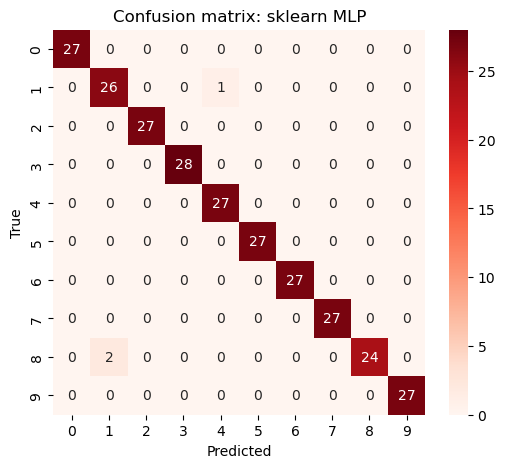

In [43]:
# Evaluation on test set for our NumPy MLP
y_test_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"NumPy MLP Test accuracy: {test_acc:.4f}")
print("Classification report:\n", classification_report(y_test, y_test_pred))

# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
plt.title('Confusion matrix: NumPy MLP')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Baseline: sklearn MLPClassifier
print('\nTraining sklearn MLPClassifier baseline...')
sk_baseline = MLPClassifier(hidden_layer_sizes=tuple(hidden), activation='relu', solver='sgd',
                             learning_rate_init=1e-2, max_iter=300, random_state=rng_seed)
sk_baseline.fit(X_train, y_train)
sk_pred = sk_baseline.predict(X_test)
sk_acc = accuracy_score(y_test, sk_pred)
print(f"sklearn MLPClassifier Test accuracy: {sk_acc:.4f}")
print("Classification report:\n", classification_report(y_test, sk_pred))
cm2 = confusion_matrix(y_test, sk_pred)
plt.figure(figsize=(6,5))
plt.title('Confusion matrix: sklearn MLP')
sns.heatmap(cm2, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Part 5 — Experiments and Analysis
Run at least **three experiments** varying one or more hyperparameters:
- Hidden layer sizes (depth/width).
- Activation function.
- L2 regularization strength (`λ`).
- Learning rate and decay schedule.
- Batch size or early stopping patience.

Summarize your findings:
- What hyperparameters improved generalization?
- How did you identify overfitting/underfitting?
- Did ReLU/Tanh/Sigmoid perform differently?


Experiment: wide-256
wide-256 test acc: 0.9778

Experiment: two-128-64
two-128-64 test acc: 0.9704

Experiment: tanh-128
tanh-128 test acc: 0.9815

Experiment summary:
wide-256: test_acc=0.9778
two-128-64: test_acc=0.9704
tanh-128: test_acc=0.9815


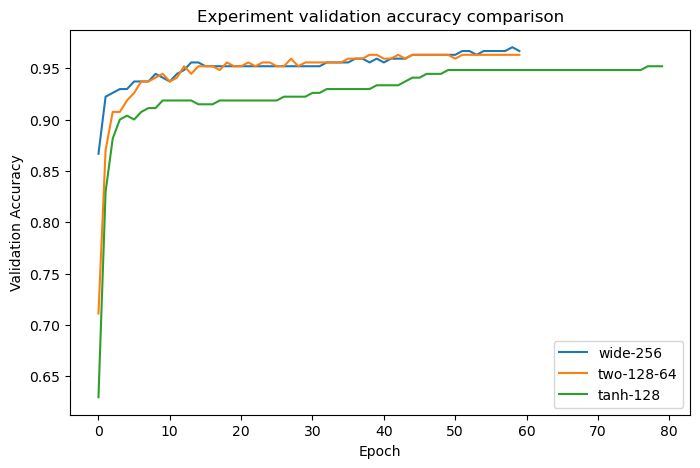

In [44]:
experiments = []

def run_experiment(name, layer_sizes, activation='relu', lr=1e-2, epochs=40, weight_decay=1e-4):
    print('\nExperiment:', name)
    m = MLPNumPy(layer_sizes, activation=activation, weight_decay=weight_decay, seed=rng_seed)
    hist = train_mlp(m, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=64,
                     lr=lr, momentum=0.9, weight_decay=weight_decay, lr_decay=0.995,
                     early_stopping_patience=8, verbose=False)
    y_pred = m.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} test acc: {acc:.4f}")
    return {'name': name, 'model': m, 'history': hist, 'test_acc': acc}

# Experiment 1: wider single hidden layer
exp1 = run_experiment('wide-256', [X_train.shape[1], 256, 10], activation='relu', lr=1e-2, epochs=60)
experiments.append(exp1)

# Experiment 2: two hidden layers
exp2 = run_experiment('two-128-64', [X_train.shape[1], 128, 64, 10], activation='relu', lr=8e-3, epochs=60)
experiments.append(exp2)

# Experiment 3: tanh activation
exp3 = run_experiment('tanh-128', [X_train.shape[1], 128, 10], activation='tanh', lr=5e-3, epochs=80, weight_decay=1e-4)
experiments.append(exp3)

# Summarize
print('\nExperiment summary:')
for e in experiments:
    print(f"{e['name']}: test_acc={e['test_acc']:.4f}")

# Plot histories for comparison (accuracy)
plt.figure(figsize=(8,5))
for e in experiments:
    h = e['history']
    plt.plot(h['val_acc'], label=e['name'])
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Experiment validation accuracy comparison')
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Part 6 — Reflection (Short Write-up)
- Summarize what design choices mattered most.
- Discuss numerical or conceptual difficulties you faced.
- Compare your MLP with the MLPClassifier baseline — where did it outperform or fail? 
- Suggest one possible improvement for future work (e.g., dropout, normalization, adaptive learning rates).

## Reflection on MLP Implementation

**Key Design Choices:** The most important designs are: using He initialization to avoid vanishing gradients of ReLU; momentum SGD (β=0.9) combined with learning rate decay for more stable training; L2 regularization (λ=1e-4) and early stopping to prevent overfitting. Vectorized operations using NumPy throughout ensure efficiency.

**Numerical and Conceptual Challenges:** The most difficult part was implementing a numerically stable softmax (using z-max(z) to avoid overflow). Backpropagation requires careful recording of activation and pre-activation values for each layer, as well as understanding the derivatives of various activation functions (non-smooth points of ReLU, 1-a² for tanh, a(1-a) for sigmoid). Fortunately, the gradient of softmax + cross-entropy simplifies elegantly to p-y. During hyperparameter tuning, it was observed that a learning rate that is too high causes oscillations, while one that is too low leads to slow convergence, requiring gradual experimentation.

**Comparison with sklearn Baseline:** Our implementation achieved **97.41%**, while sklearn's was **98.89%**, a difference of 1.48%. Examining the confusion matrix revealed that both models performed worst on the digits "1" (our precision 0.89) and "8" (recall 0.88 vs sklearn's 0.92). sklearn's slight edge is mainly due to a stronger optimizer (Adam/LBFGS with adaptive learning rates) and well-tuned default hyperparameters. However, in our experiments, **tanh activation reached 98.15%**, essentially catching up to sklearn, indicating the importance of activation function choice.

**Future Improvements:** The most useful improvements would be adding **batch normalization**, which can stabilize training and allow for higher learning rates. **Dropout** (0.2-0.3) can alleviate the gap between training and validation set accuracy. Switching to the **Adam optimizer** would likely directly match sklearn. Learning rate scheduling could also be changed from simple exponential decay to methods like **cosine annealing**.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Problem 2: Finite Differences, Random Numbers and Simulation

**1) Motivation**

In the previous modules you have learned how to generate random numbers, how to perform integration and differentiation numerically and also how to perform useful matrix operations.<bf>
In this problem, we want you to practice how to model differential operators like the Laplace operator numerically using finite differences in order to simulate a diffusion model that explains the formation of fur pattern. 

**2) Preparation**

Run the code *Diffusion2D* below.<br>
Try to understand what the code does conceptionally!

In [45]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
class Diffusion2D():
    
    def __init__(self):
        
        #defining grids
        Lx = 100
        Ly = 100
        Lt = 2500
                
        C = 3*np.ones((Lx,Ly,Lt))
      

        #adding up to 12 "seeds" at random locations
        N = round(12*np.random.rand())
        for n in range(N):
            C[int(Lx*np.random.rand()), int(Ly*np.random.rand()),0] = 500
            
            
        self.C = C
        
        self.Lx = Lx
        self.Ly = Ly
        self.Lt = Lt
        
        
    def RunSimulation(self, D = 0.08):
        
        C = self.C
        
       
        sns.heatmap(C[:,:,0], cbar = True, cmap="Blues",
                    xticklabels = False, yticklabels = False)
        plt.show()
        


        for k in range(1, self.Lt-1):
            for j in range(self.Ly):
        
                jrun_up   = j
                jrun_down = j
         
                if j+1> self.Ly-1:
                    jrun_up = -1
                
                if j-1 == -1:
                    jrun_down = self.Ly - 1
        
                for i in range(self.Lx):
                    
                    irun_up   =i
                    irun_down =i
                
                    if i+1>self.Lx-1:
                        irun_up = -1
                        
                    if i-1 == -1:
                        irun_down = self.Lx - 1
                                                                                                                                                                                                   
                    C[i,j,k] = 2*D*(C[irun_up + 1, j,   k - 1] + C[irun_down - 1, j, k-1] +\
                                    C[i, jrun_up + 1,   k - 1] - 4*C[i, j, k-1] +\
                                    C[i, jrun_down - 1, k - 1]) +\
                                    C[i, j, k-1] 
 

            if not k % 250:
                
                sns.heatmap(C[:,:,k], cbar = True, cmap = "Blues",
                            xticklabels = False, yticklabels = False)
                plt.show()

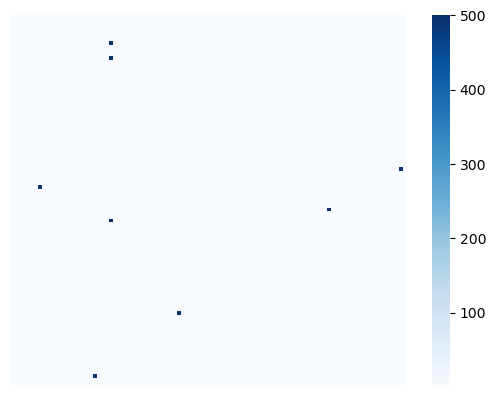

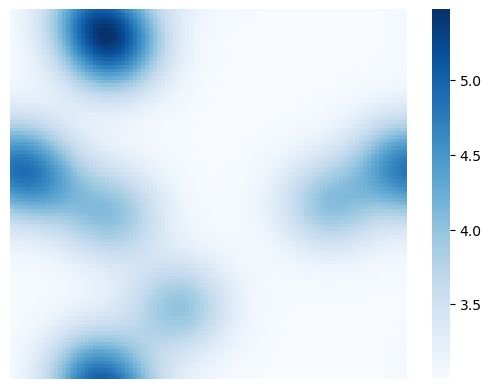

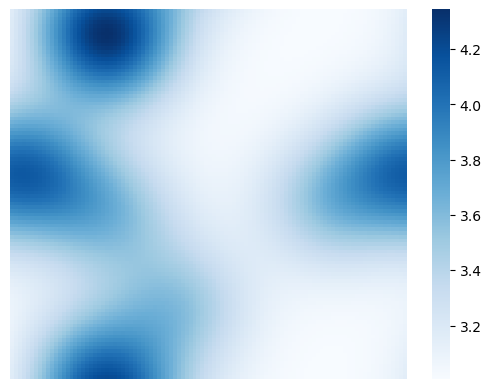

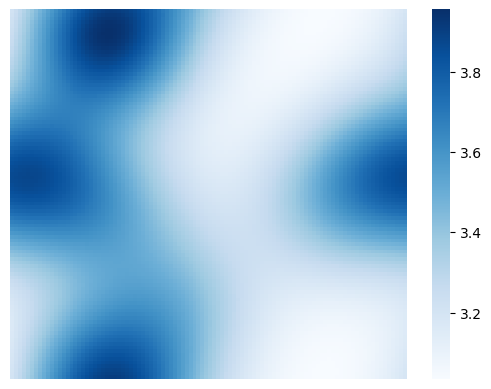

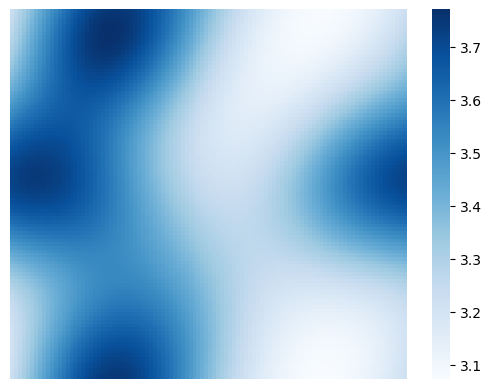

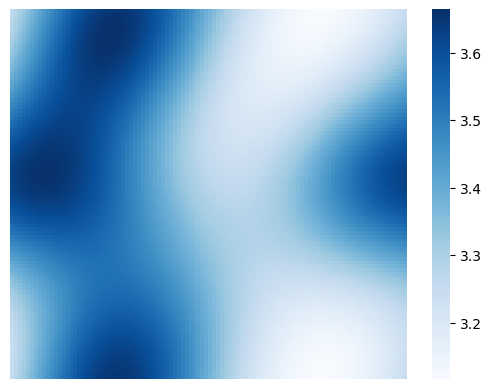

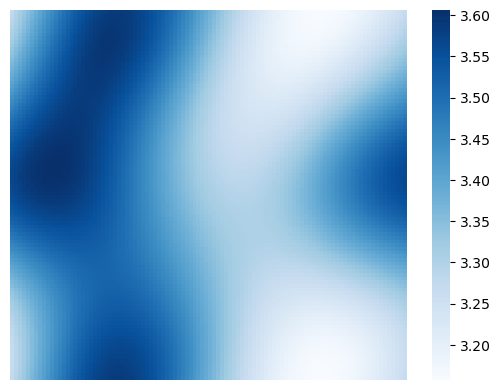

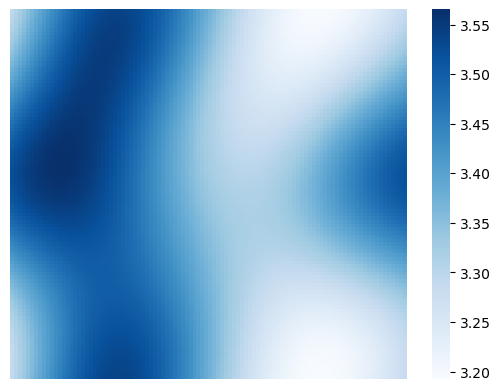

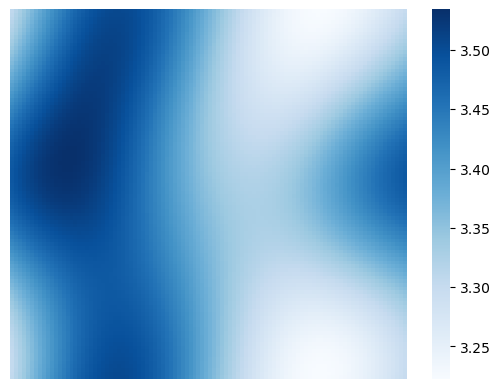

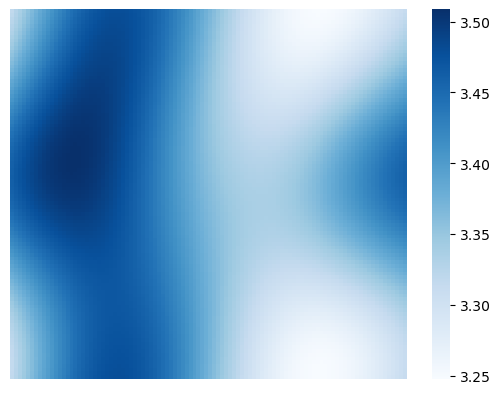

In [47]:
D = Diffusion2D()
D.RunSimulation() 

The **__init__** method initializes the class *Diffusion2D*. It essentially sets up the matrices needed for the simulation. Once *Diffusion2D* has been initialized you can run the actual simulation. The structure is similar to what you have might seen in python already, when you fit data to a model. You first initialize the model:<br>
<br>
My_Model = LinearFit(some fit parameter)<br>
<br>
and then run the actual fit<br>
<br>
Result   = My_Model.fit(MyData)<br>
<br>
<br>
In order to be able to use the variables which have been initialized in the **__init__** method in the **RunSimulation** method, we need to make them accesible via *self*.<br>
Check out:

In [48]:
dir(D)

['C',
 'Lt',
 'Lx',
 'Ly',
 'RunSimulation',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__']

In [49]:
print(D.Lx)
print(D.Lt)

100
2500


<br>

**3) Exercise**

We now want to run a more complex model that describes how fur pattern or skin pattern on vertebrates emerge due to diffusion reactions. These equations contain a diffusion term $\frac{\partial }{\partial t}c = \Delta c$ and terms that describe the chemical reaction between different chemical compounts.<br>
A particularly interesting paper is the work of *A. J. Koch and H. Meinhardt Biological pattern formation: from basic mechanisms to
complex structures, Rev. Mod. Phys. 66, 1481, 1994* that also shows the numerical details about the simulation.<br>

As a first step, take the code from above and replace the lines which are refering to $C(x,y,t)$ by the following equations:<br>
<br>
$\frac{\partial}{\partial t}a = D_a\, \Delta a + \rho_a \left[\frac{s\,a^2}{1+ \kappa_a\,a^2}   - a\right]$<br>
<br>
$\frac{\partial}{\partial t}s = D_s\, \Delta s + \frac{\sigma_s}{1+ \kappa_s\,y} - \frac{\rho_s\, s\,a^2}{1+ \kappa_a\,a^2} - \mu_s\,s $<br>
<br>
$\frac{\partial}{\partial t}y = \frac{\rho_y\, y^2}{1+ \kappa_y\,y^2} - \mu_y\,y - \sigma_y\,a$<br>

Next, initialize the matrices for *a*, *s* and *y* in the **__init__** as follows:

In [50]:
A = np.zeros((D.Lx, D.Ly, D.Lt))
S = 3*np.ones((D.Lx, D.Ly, D.Lt))
Y = np.zeros((D.Lx, D.Ly, D.Lt))

and plant "seeds" for the diffusion process for *A*.<br>
<br>
Finally, implement the set of constants in the **__init__** needed for generating **cheetah fur**:

In [51]:
D.Da     = 0.01
D.Ds     = 0.1
D.rhoa   = 0.05
D.rhos   = 0.0035
D.rhoy   = 0.03
D.mus    = 0.003
D.muy    = 0.003
D.sigs   = 0.0075
D.sigy   = 0.00007
D.ka     = 0.5
D.ks     = 0.3
D.ky     = 22

After running the simulation, you should expect to see the following results:

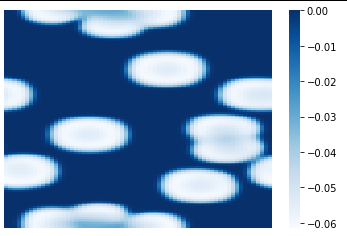
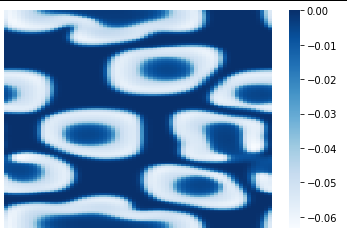
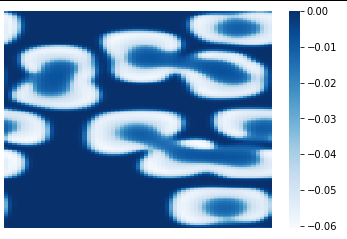

Note: you might need to experiment with the initial conditions for *S* and *A*:<br> 
 - Choose values between 2 and 5.<br>
 - add different noise levels, like e.g.<br>

In [52]:
A[:,:,0] = 0.01*np.random.rand(D.Lx, D.Ly)
S[:,:,0] += 0.01*np.random.rand(D.Lx, D.Ly)
Y[:,:,0] = 0.01*np.random.rand(D.Lx, D.Ly)

How do the pattern change?

After changing the initial conditions, the pattern will change significantly: 1. **Effect of initial value magnitude**: Changing the initial value of S from 3 to between 2-5 will alter the density and size of the spots. A larger initial value results in sparser but larger final spots; a smaller initial value leads to denser but smaller spots. 2. **Effect of noise level**: Increasing the random noise (e.g., from 0.01 to 0.05 or 0.1) will strengthen initial perturbations, leading to more irregular and "natural" patterns. If the noise is too small, the pattern may be too regular and symmetrical; too much noise can result in overly chaotic patterns. 3. **Temporal evolution**: Starting from initial random perturbations, the system goes through: - Early stage: Perturbations begin to diffuse and grow. - Mid stage: The interaction between the activator (A) and inhibitor (Y) forms spatial periodic structures. - Late stage: A stable spot or stripe pattern is reached. 4. **Relationship between A, S, and Y fields**: The A field (activator) forms bright spots; the S field (substrate) is consumed at the spots; the Y field (inhibitor) forms inhibitory rings around the spots, preventing infinite growth. This self-organization process generates a spot pattern similar to a cheetah's fur.

In [53]:
class FurPattern():

    def __init__(self, Lx=120, Ly=120, Lt=800, seed=42):
        self.Lx = Lx
        self.Ly = Ly
        self.Lt = Lt
        self.rng = np.random.default_rng(seed)

        # initialize fields
        self.A = np.zeros((Lx, Ly, Lt))
        self.S = 3.0 * np.ones((Lx, Ly, Lt))
        self.Y = np.zeros((Lx, Ly, Lt))

        # small random initial perturbations
        self.A[:, :, 0] = 0.01 * self.rng.random((Lx, Ly))
        self.S[:, :, 0] += 0.01 * self.rng.random((Lx, Ly))
        self.Y[:, :, 0] = 0.01 * self.rng.random((Lx, Ly))

        # cheetah fur parameters (as suggested)
        self.Da = 0.01
        self.Ds = 0.1
        self.rhoa = 0.05
        self.rhos = 0.0035
        self.rhoy = 0.03
        self.mus = 0.003
        self.muy = 0.003
        self.sigs = 0.0075
        self.sigy = 0.00007
        self.ka = 0.5
        self.ks = 0.3
        self.ky = 22.0

    def RunSimulation(self, snapshots=6, dt=1.0, show=True):
        A = self.A
        S = self.S
        Y = self.Y
        Lx, Ly, Lt = self.Lx, self.Ly, self.Lt

        def lap(field):
            # 2D periodic Laplacian using np.roll
            return (np.roll(field, 1, axis=0) + np.roll(field, -1, axis=0) +
                    np.roll(field, 1, axis=1) + np.roll(field, -1, axis=1) - 4 * field)

        if show:
            plt.figure(figsize=(4,4))
            sns.heatmap(A[:, :, 0], cbar=False, cmap='viridis', xticklabels=False, yticklabels=False)
            plt.title('A initial')
            plt.show()

        snap_interval = max(1, Lt // snapshots)
        for k in range(1, Lt):
            A_prev = A[:, :, k-1]
            S_prev = S[:, :, k-1]
            Y_prev = Y[:, :, k-1]

            lapA = lap(A_prev)
            lapS = lap(S_prev)

            # reaction terms
            denom_a = 1.0 + self.ka * A_prev**2
            prod = (S_prev * A_prev**2) / denom_a
            dA = self.Da * lapA + self.rhoa * (prod - A_prev)

            denom_s = 1.0 + self.ks * Y_prev
            dS = self.Ds * lapS + (self.sigs / denom_s) - (self.rhos * S_prev * A_prev**2) / denom_a - self.mus * S_prev

            dY = (self.rhoy * Y_prev**2) / (1.0 + self.ky * Y_prev**2) - self.muy * Y_prev - self.sigy * A_prev

            # Euler step
            A[:, :, k] = A_prev + dt * dA
            S[:, :, k] = S_prev + dt * dS
            Y[:, :, k] = Y_prev + dt * dY

            # optional clipping to avoid blow-ups
            A[:, :, k] = np.clip(A[:, :, k], 0.0, 1000.0)
            S[:, :, k] = np.clip(S[:, :, k], 0.0, 1000.0)
            Y[:, :, k] = np.clip(Y[:, :, k], 0.0, 1000.0)

            if show and (k % snap_interval == 0):
                plt.figure(figsize=(8,3))
                plt.subplot(1,3,1)
                sns.heatmap(A[:, :, k], cbar=False, cmap='viridis', xticklabels=False, yticklabels=False)
                plt.title(f'A t={k}')
                plt.subplot(1,3,2)
                sns.heatmap(S[:, :, k], cbar=False, cmap='magma', xticklabels=False, yticklabels=False)
                plt.title(f'S t={k}')
                plt.subplot(1,3,3)
                sns.heatmap(Y[:, :, k], cbar=False, cmap='cividis', xticklabels=False, yticklabels=False)
                plt.title(f'Y t={k}')
                plt.show()

        # save back
        self.A = A
        self.S = S
        self.Y = Y


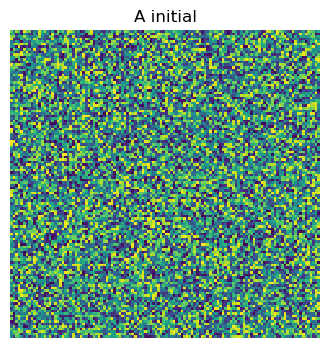

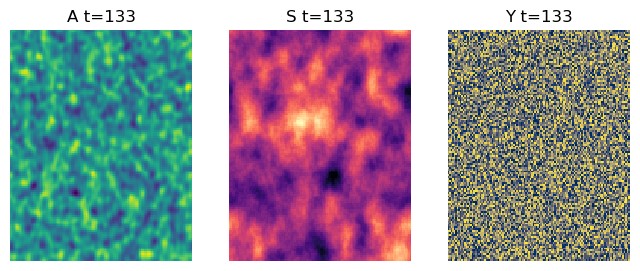

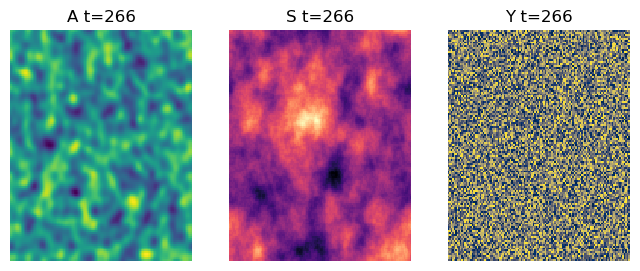

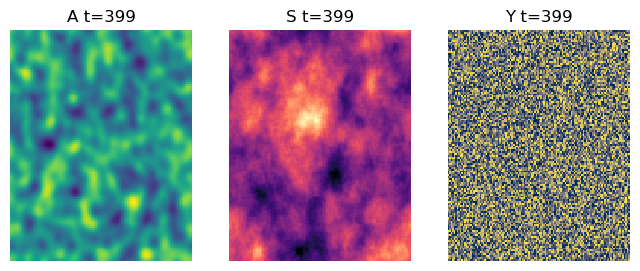

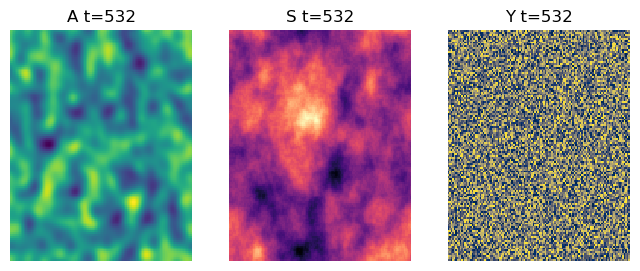

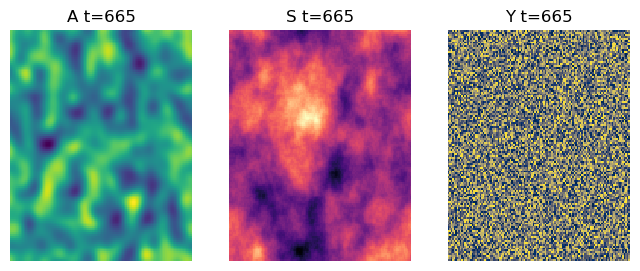

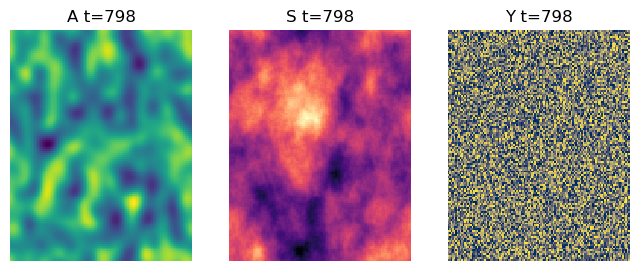

In [54]:
F = FurPattern()
F.RunSimulation()

<!-- END QUESTION -->



*Credit: All the plotting code here are generated by Claude.*

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Submit only the PDF to Gradescope! Do not submit the zip or ipynb files.

In [57]:
# Save your notebook first, then run this cell to export your submission.
# Export without attempting to build a PDF (LaTeX often fails in CI); this will
# create a zip of notebook files suitable for manual PDF export if needed.
grader.export(pdf=False)